In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim


In [16]:
# 1. CIFAR-10 betöltése
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)



In [22]:
# 2. CNN modell (RGB-hez igazítva)
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super(CIFAR_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5)   # 3 → 8 csatorna
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)  # 8 → 16
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 6 * 6, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = self.fc1(x)
        return x  # Csak a végső kimenetet add vissza!



In [23]:
class FeatureVisualizer(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        out1 = self.model.conv1(x)
        out2 = self.model.relu1(out1)
        out3 = self.model.pool1(out2)
        out4 = self.model.conv2(out3)
        out5 = self.model.relu2(out4)
        out6 = self.model.pool2(out5)
        return [x, out1, out2, out3, out4, out5, out6]

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
model = CIFAR_CNN().to(device)

# 3. Tanítás beállítása
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
loss_list = []


In [26]:
# 4. Tanítási ciklus
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_list.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")



Epoch [1/10], Loss: 1.6896
Epoch [2/10], Loss: 1.4267
Epoch [3/10], Loss: 1.3440
Epoch [4/10], Loss: 1.2747
Epoch [5/10], Loss: 1.2242
Epoch [6/10], Loss: 1.1859
Epoch [7/10], Loss: 1.1579
Epoch [8/10], Loss: 1.1324
Epoch [9/10], Loss: 1.1187
Epoch [10/10], Loss: 1.0988


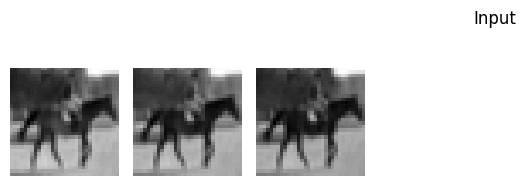

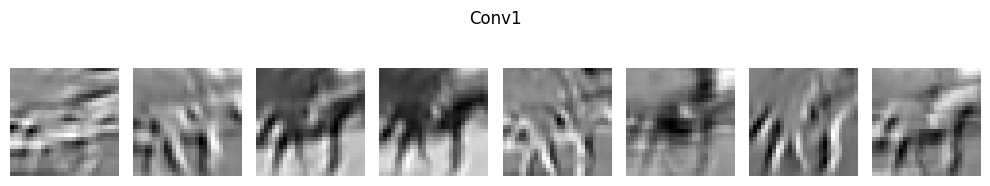

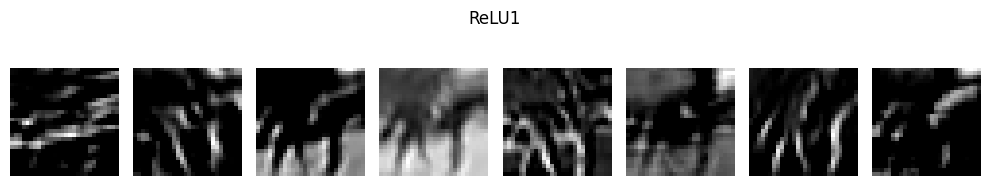

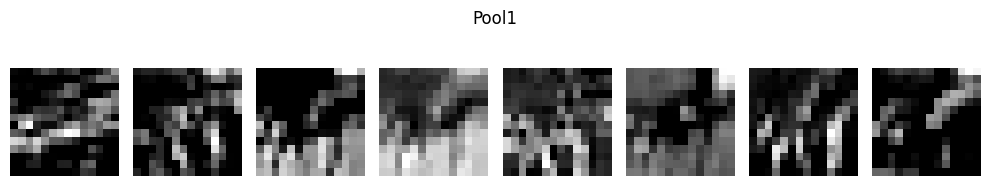

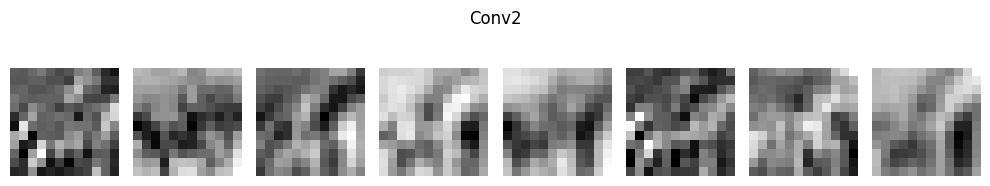

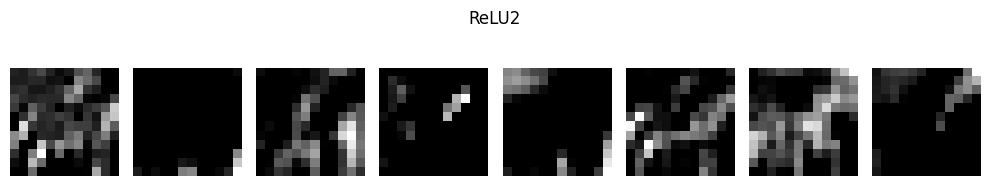

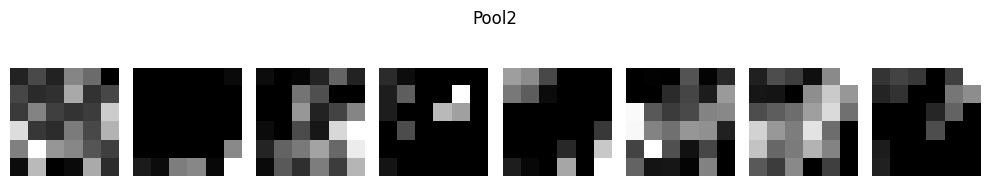

In [27]:
visualizer = FeatureVisualizer(model).to(device)
images, _ = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    feature_maps = visualizer(images)

layer_names = ["Input", "Conv1", "ReLU1", "Pool1", "Conv2", "ReLU2", "Pool2"]

for i, fmap in enumerate(feature_maps):
    fmap = fmap.squeeze(0).cpu()
    plt.figure(figsize=(10, 2))
    plt.suptitle(layer_names[i])
    for j in range(min(fmap.shape[0], 8)):
        plt.subplot(1, 8, j+1)
        plt.imshow(fmap[j], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

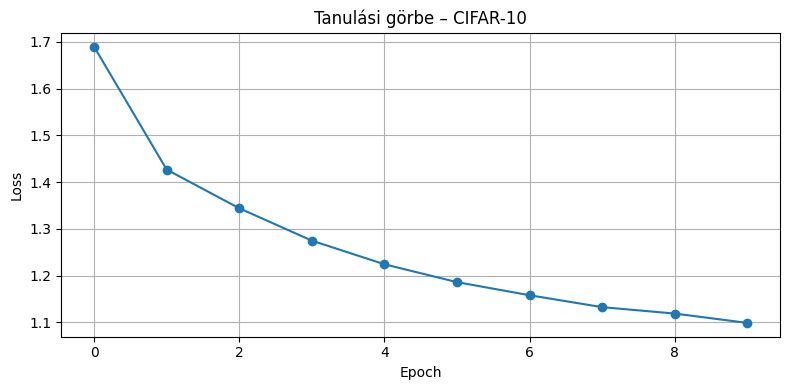

In [28]:
# 5. Tanulási görbe kirajzolása
plt.figure(figsize=(8, 4))
plt.plot(loss_list, marker='o')
plt.title('Tanulási görbe – CIFAR-10')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()